Before talking about binomial option pricing model, let's do a small recap on how we can derive the price of an option in general. So basically we can do it in three ways using:
- Binomial option pricing model
- Black-Scholes model
- Monte Carlo method

The binomial option pricing model is a tool for calculating the theoretical value of options. It is relatively simple to understand and use, especially compared to more complicated models like the Black-Scholes model. The binomial model is based on the idea that it should be impossible to make a risk-free profit through arbitrage. This means that the price of an option should reflect the balance of potential outcomes and the probabilities of those outcomes occurring. Despite its simplicity, the binomial model can be used to price a wide range of options and is often used as a benchmark against which more complex models are compared.

In this particular mini project we use Python tools to implement a T-period binomial option pricing model and compare it to the Monte Carlo method.
  
The stock starts out at a price S at time 0 and, at every time period can
have a gross return of either $R_u$ or $R_d$ , with $R_u > 1 > R_d$. We assume the interest
rate is zero and $R_u$ and $R_d$ are the same every period. We try to price a call option with strike price $K$.

$\boldsymbol{a}$. Let’s start with the explicit method: we write a function that generate a (T + 1) by (T + 1) matrix, where the upper triangle contains the prices at
each time (columns) in each of the respective states of the world (rows). We start with period T and then calculate the prices at time T − 1.
By backward induction, we argue that the top left entry gives the call
price at time 0.

In [10]:
import numpy as np
import numpy.random as ran
import sympy as sym
from sympy.matrices import Matrix, zeros
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.animation as animation


from matplotlib import style
style.use('dark_background')

The risk neutral probability (q) is given by: $\frac{(e^{r*T}-R_d)}{(R_u-R_d)}$

In [11]:
def price_matrices(T, R_u, R_d, S, K, q=None, r=0):
    if not q: q = (np.e**(r*T)-R_d)/(R_u-R_d)
        
    # first, initialize (T+1) x (T+1) matrix as a zero-matrix
    s_matrix = zeros(T+1)
    c_matrix = zeros(T+1)
    
    for t in range(T, -1, -1): # t corresponds to the column, we start at T and iteratively go back in time
        for w in range(t+1): # w corresponds to the row
            # first, create a binomial tree as in the lecture.
            # given a column representing time t, it must hold that:
            # the first row in the column must always have (R_u)^t * (R_d)^0 * S
            # the next rows then have decending exponents of R_u and ascending exponents of R_d
            # the last row must always have (R_u)^0 * (R_d)^t * S
            s_matrix[w, t] = R_u**(t-w)*R_d**(w)*S
            
            # now create a matrix for the option prices
            if t==T: # start by calculating option prices for t=T
                c_matrix[w, t] = sym.Max(s_matrix[w, t]-K, 0)
            elif t<T: # for t<T option prices can be calculated from prices at t+1 using the implied probability
                c_matrix[w, t] = np.e**(-r*T)*(q*c_matrix[w, t+1] + (1-q)*c_matrix[w+1, t+1])
    
    return s_matrix, c_matrix

In [12]:
# choose some arbitrary value for T
T = 2
# define variables for symbolic calculations
R_u = sym.Symbol("R_u")
R_d = sym.Symbol("R_d")
S = sym.Symbol("S")
K = sym.Symbol("K")
q = sym.Symbol("q")

s_matrix, c_matrix = price_matrices(T, R_u, R_d, S, K, q)

print("This is what the upper triangle matrix of stock prices looks like (T={}):".format(T))
display(s_matrix)

print("This is what the upper triangle matrix of option prices looks like:")
display(c_matrix)

This is what the upper triangle matrix of stock prices looks like (T=2):


Matrix([
[S, R_u*S,  R_u**2*S],
[0, R_d*S, R_d*R_u*S],
[0,     0,  R_d**2*S]])

This is what the upper triangle matrix of option prices looks like:


Matrix([
[1.0*q*(1.0*q*Max(0, -K + R_u**2*S) + 1.0*(1 - q)*Max(0, -K + R_d*R_u*S)) + 1.0*(1 - q)*(1.0*q*Max(0, -K + R_d*R_u*S) + 1.0*(1 - q)*Max(0, -K + R_d**2*S)), 1.0*q*Max(0, -K + R_u**2*S) + 1.0*(1 - q)*Max(0, -K + R_d*R_u*S),  Max(0, -K + R_u**2*S)],
[                                                                                                                                                        0, 1.0*q*Max(0, -K + R_d*R_u*S) + 1.0*(1 - q)*Max(0, -K + R_d**2*S), Max(0, -K + R_d*R_u*S)],
[                                                                                                                                                        0,                                                                0,  Max(0, -K + R_d**2*S)]])

In [13]:
# now this is what these values would look like for explicit values of S, R_d, and R_u:
S = 20
K = 21
R_u = 1.1
R_d = 0.9

s_matrix, c_matrix = price_matrices(T, R_u, R_d, S, K)

display(Markdown(
    "Example of what this looks like with $r$={}, $S$={}, $K$={}, $R_u$={}, $R_d$={}:".format(
        0, S, K, R_u, R_d)))

print("Matrix of stock prices:")
display(s_matrix)
print("Matrix of option prices:")
display(c_matrix)

Example of what this looks like with $r$=0, $S$=20, $K$=21, $R_u$=1.1, $R_d$=0.9:

Matrix of stock prices:


Matrix([
[20.0, 22.0, 24.2],
[   0, 18.0, 19.8],
[   0,    0, 16.2]])

Matrix of option prices:


Matrix([
[0.8, 1.6, 3.2],
[  0,   0,   0],
[  0,   0,   0]])

$\boldsymbol{b}$. Now for the Monte Carlo method: we write a function that generates N sample paths of the price process according to the risk-neutral measure. For each sample path, take the corresponding final value
of the option. As output, let the code plot for $1 ≤ n ≤ N$ the running average of these final values.

In [14]:
def monte_carlo(N, T, R_u, R_d, S, K, r=0):
    q = (np.e**(r*T)-R_d)/(R_u-R_d)
        
    final_values = []
    for n in range(N):
        val = S # initialize with value S
        for t in range(T): # now iteratively go through each time step
            R_next = ran.choice([R_u, R_d], p = [q, (1-q)])
            val = R_next*val
            
        # save final value
        final_values.append(max(val-K, 0))
        
    return final_values

$\boldsymbol{c}$. For $T = 100$, $R_u = 1.02$ and $R_d = .99$, we find the price of an at-the-money call option explicitly. We show that the running average from the Monte Carlo method converges to the price obtained explicitly. +
$\boldsymbol{d}$. Plot the results.

Option price at time t=0: 1.12702550770902


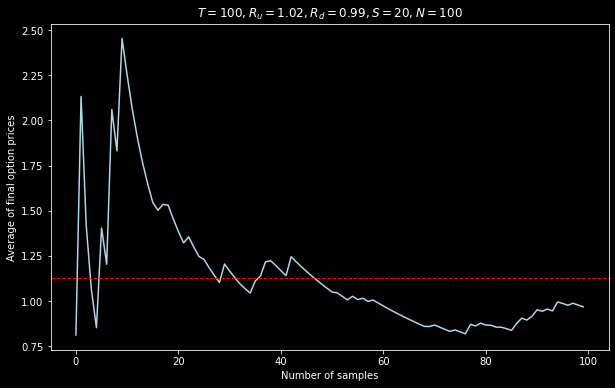

In [15]:
T = 100
R_u = 1.02
R_d = 0.99
S = K = 20

s_matrix, c_matrix = price_matrices(T, R_u, R_d, S, K)
# value of the option at the current time
print("Option price at time t=0:", c_matrix[0,0])

N = 100 

vals = monte_carlo(N, T, R_u, R_d, S, K)
running_avg = [np.mean(vals[:n]) for n in range(1, N+1)]

plt.figure(figsize=(10,6))
plt.title(r"$T={}, R_u={}, R_d={}, S={}, N={}$".format(T, R_u, R_d, S, N))
plt.plot(running_avg, color="lightblue")
plt.xlabel("Number of samples")
plt.ylabel("Average of final option prices")
plt.axhline(c_matrix[0,0], color="red", linestyle="dashed", linewidth=1)
plt.show()

$\boldsymbol{e}$. We use an animation to represent the results graphically.

In [16]:
x = np.array(range(1,101, 1))
y = np.array(running_avg)
y = y[:101]


y1 = np.repeat(c_matrix[0,0],101)

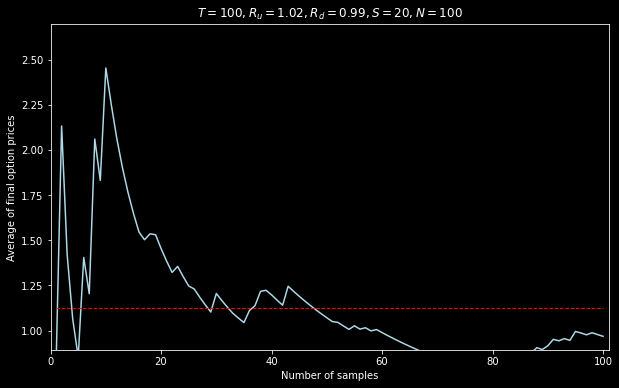

In [17]:
tfinal = 101
x0 = 0
# animation line plot example

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

def animate(i):
    ax.cla() # clear the previous image
    ax.plot(x[:i], y[:i], color="lightblue")# plot the line
    ax.plot(x[:i], y1[:i], color="red", linestyle="dashed", linewidth=1)
    ax.set_xlim([x0, tfinal]) # fix the x axis
    ax.set_ylim([1.1*np.min(y), 1.1*np.max(y)]) # fix the y axis
    
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Average of final option prices")
    ax.set_title(r"$T={}, R_u={}, R_d={}, S={}, N={}$".format(T, R_u, R_d, S, N))

anim = animation.FuncAnimation(fig, animate, frames = len(x) + 1, interval = 10, blit = False)

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
from IPython.display import HTML
HTML(anim.to_jshtml())